# Lab 7a: Convolutional neural nets
In this lab we consider the [CIFAR dataset](https://www.openml.org/d/40926), but model it using convolutional neural networks instead of linear models.
There is no separate tutorial, but you can find lots of examples in the lecture notebook on convolutional neural networks. If you are very confident, you can also try to solve these exercises using PyTorch instead of TensorFlow.

Tip: You can run these exercises faster on a GPU (but they will also run fine on a CPU). If you do not have a GPU locally, you can upload this notebook to Google Colab. You can enable GPU support at “runtime” -> “change runtime type”.

In [1]:
# General imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openml as oml
import tensorflow as tf

In [2]:
# Uncomment the next line if you run on Colab
#!pip install --quiet openml

In [2]:
%matplotlib inline
import openml as oml
import matplotlib.pyplot as plt

In [ ]:
# Download CIFAR data. Takes a while the first time.
# This version returns 3x32x32 resolution images. 
# If you feel like it, repeat the exercises with the 96x96x3 resolution version by using ID 41103 
cifar = oml.datasets.get_dataset(40926) 
X, y, _, _ = cifar.get_data(target=cifar.default_target_attribute, dataset_format='array'); 
cifar_classes = {0: "airplane", 1: "automobile", 2: "bird", 3: "cat", 4: "deer",
                 5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"}

In [4]:
# The dataset (40926) is in a weird 3x32x32 format, we need to reshape and transpose
Xr = X.reshape((len(X),3,32,32)).transpose(0,2,3,1)

In [5]:
Xr.shape

(20000, 32, 32, 3)

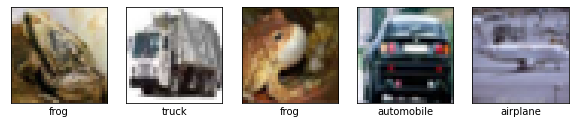

In [6]:
# Take some random examples, reshape to a 32x32 image and plot
from random import randint
fig, axes = plt.subplots(1, 5,  figsize=(10, 5))
for i in range(5):
    n = randint(0,len(Xr))
    # The data is stored in a 3x32x32 format, so we need to transpose it
    axes[i].imshow(Xr[n]/255)
    axes[i].set_xlabel((cifar_classes[int(y[n])]))
    axes[i].set_xticks(()), axes[i].set_yticks(())
plt.show();

In [8]:
np.unique(y) # 10 classes

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [9]:
cifar_classes

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

## Exercise 1: A simple model
* Split the data into 80% training and 20% validation sets
* Normalize the data to [0,1]
* Build a ConvNet with 3 convolutional layers interspersed with MaxPooling layers, and one dense layer.
    * Use at least 32 3x3 filters in the first layer and ReLU activation.
    * Otherwise, make rational design choices or experiment a bit to see what works.
* You should at least get 60% accuracy.
* For training, you can try batch sizes of 64, and 20-50 epochs, but feel free to explore this as well
* Plot and interpret the learning curves. Is the model overfitting? How could you improve it further?

In [ ]:
# Helper plotting function
#
# history: the history object returned by the fit function
# list_of_metrics: the metrics to plot
def plot_curve(history, show_loss=True):
    
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")

    epochs = np.array(history.epoch) + 1
    hist = pd.DataFrame(history.history)
    
    if show_loss:
        plt.plot(epochs, hist["loss"], label="loss", lw=2, c="red")
        plt.plot(epochs, hist["val_loss"], label="val_loss", lw=2, c="blue")
    plt.plot(epochs, hist["categorical_accuracy"], label="accuracy", lw=2, c="red", linestyle="--")
    plt.plot(epochs, hist["val_categorical_accuracy"], label="val_accuracy", lw=2, linestyle="--", c="blue")

    plt.legend()

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(Xr, y, 
                                                  stratify=y, 
                                                  shuffle=True,
                                                  random_state=123,
                                                  train_size=0.8)

In [27]:
X_train /= 255
X_val /= 255
y_train = tf.one_hot(y_train, depth=10)
y_val = tf.one_hot(y_val, depth=10)

In [47]:
# define model layers
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(32, 32, 3)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation="relu"))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation="relu"))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation="relu"))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation="relu"))
model.add(tf.keras.layers.Dense(10))

In [48]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 15, 15, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 13, 13, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 6, 6, 128)         0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 4, 4, 128)         147584    
                                                                 
 flatten_3 (Flatten)         (None, 2048)             

In [49]:
# add loss, optimizer and metrics
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [50]:
history = model.fit(X_train, y_train, 
                    epochs=60,
                    steps_per_epoch=100,
                    batch_size=64,
                    validation_data=(X_val, y_val))

Epoch 1/60
100/100 [==============================] - 12s 118ms/step - loss: 2.2120 - categorical_accuracy: 0.1883 - val_loss: 2.1184 - val_categorical_accuracy: 0.2155
Epoch 2/60
100/100 [==============================] - 12s 117ms/step - loss: 2.0338 - categorical_accuracy: 0.2672 - val_loss: 1.9815 - val_categorical_accuracy: 0.2820
Epoch 3/60
100/100 [==============================] - 12s 124ms/step - loss: 1.9215 - categorical_accuracy: 0.3055 - val_loss: 1.8810 - val_categorical_accuracy: 0.3175
Epoch 4/60
100/100 [==============================] - 13s 131ms/step - loss: 1.8362 - categorical_accuracy: 0.3353 - val_loss: 1.8515 - val_categorical_accuracy: 0.3295
Epoch 5/60
100/100 [==============================] - 13s 130ms/step - loss: 1.7945 - categorical_accuracy: 0.3584 - val_loss: 1.7926 - val_categorical_accuracy: 0.3623
Epoch 6/60
100/100 [==============================] - 13s 131ms/step - loss: 1.7393 - categorical_accuracy: 0.3727 - val_loss: 1.7762 - val_categorical_acc

100/100 [==============================] - 13s 130ms/step - loss: 1.0887 - categorical_accuracy: 0.6194 - val_loss: 1.1912 - val_categorical_accuracy: 0.5860
Epoch 50/60
100/100 [==============================] - 13s 130ms/step - loss: 1.0766 - categorical_accuracy: 0.6253 - val_loss: 1.1714 - val_categorical_accuracy: 0.5880
Epoch 51/60
100/100 [==============================] - 13s 131ms/step - loss: 1.0777 - categorical_accuracy: 0.6217 - val_loss: 1.1407 - val_categorical_accuracy: 0.5982
Epoch 52/60
100/100 [==============================] - 13s 130ms/step - loss: 1.0491 - categorical_accuracy: 0.6364 - val_loss: 1.1771 - val_categorical_accuracy: 0.5960
Epoch 53/60
100/100 [==============================] - 13s 131ms/step - loss: 1.0519 - categorical_accuracy: 0.6330 - val_loss: 1.1413 - val_categorical_accuracy: 0.6018
Epoch 54/60
100/100 [==============================] - 13s 131ms/step - loss: 1.0468 - categorical_accuracy: 0.6411 - val_loss: 1.1261 - val_categorical_accuracy:

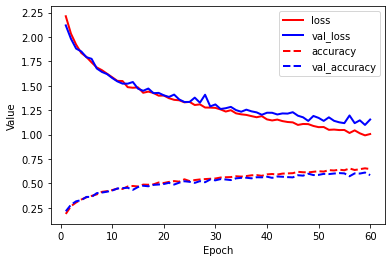

In [51]:
plot_curve(history)

* Although in last epoch the accuracy is lower, using early stopping one could obtain even 61% accuracy on validation data(epoch 59).
* The model is somewhat overfitting.

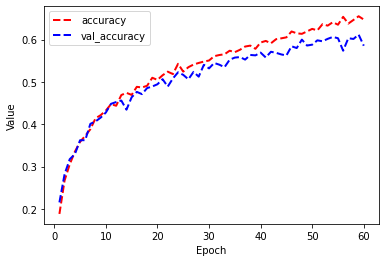

In [52]:
plot_curve(history, False) # zoom to accuracies

## Exercise 2: VGG-like model
* Implement a simplified VGG model by building 3 'blocks' of 2 convolutional layers each
* Do MaxPooling after each block
* The first block should use at least 32 filters, later blocks should use more
* You can use 3x3 filters
* Use zero-padding to be able to build a deeper model (see the `padding` attribute)
* Use a dense layer with at least 128 hidden nodes.
* You can use ReLU activations everywhere (where it makes sense)
* Plot and interpret the learning curves


## Exercise 3: Regularization
* Explore different ways to regularize your VGG-like model
  * Try adding some dropout after every MaxPooling and Dense layer.
    * What are good Dropout rates? Try a fixed Dropout rate, or increase the rates in the deeper layers.
  * Try batch normalization together with Dropout
    * Think about where batch normalization would make sense 
* Plot and interpret the learning curves


## Exercise 4: Data Augmentation
* Perform image augmentation (rotation, shift, shear, zoom, flip,...). You can use the ImageDataGenerator for this.
* What is the effect? What is the effect with and without Dropout?
* Plot and interpret the learning curves


## Exercise 5: Interpret the misclassifications
Chances are that even your best model is not yet perfect. It is important to understand what kind of errors it still makes.
* Run the test images through the network and detect all misclassified ones
* Interpret some of the misclassifications. Are these misclassifications to be expected? 
* Compute the confusion matrix. Which classes are often confused?

## Exercise 6: Interpret the model
Retrain your best model on all the data. Next, retrieve and visualize the activations (feature maps) for every filter for every convolutional layer, or at least for a few filters for every layer. Tip: see the course notebooks for examples on how to do this. 

Interpret the results. Is your model indeed learning something useful?

## Optional: Take it a step further
* Repeat the exercises, but now use a [higher-resolution version of the CIFAR dataset](https://www.openml.org/d/40926) (with OpenML ID 41103), or another [version with 100 classes](https://www.openml.org/d/41983) (with OpenML ID 41983). Good luck!
